In [9]:
import numpy as np
import pandas as pd
import pyodbc
import seaborn as sns
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import math
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
#from bokeh.io import output_notebook, show, curdoc, output_file,push_notebook
#from bokeh.layouts import widgetbox, row
#from bokeh.plotting import figure
#from bokeh.models import HoverTool, ColumnDataSource, Slider, CDSView, GroupFilter,BooleanFilter
#from bokeh.transform import factor_cmap
#from bokeh.palettes import all_palettes
#from bokeh.models.widgets import TextInput

online = 0
if online == 1:
    conn=pyodbc.connect('Driver={SQL Server};'
                          'Server=balt-sql-fc;'
                          'Database=CitiStat;'
                          'Trusted_Connection=yes;')


In [4]:
def due_date(create_date,sla):
    due = dt.datetime.strptime(create_date, '%Y-%m-%d').date() + dt.timedelta(days=sla)
    return str(due)
def lower_str(text):
    return text.lower()
def textstr2date(text):
    if pd.notnull(text):
        new_str=str(text)[0:10]
    else:
        new_str = text
    return new_str
def oopen(data_inp,date_comp):
    #COUNTS NUMBER OPEN
    count_close=len(data_inp[(data_inp['Date_Create']<date_comp)&((data_inp['Status'].apply(lower_str).str.contains('close'))&(data_inp['Date_Finish']>date_comp))])
    count_cancel=len(data_inp[(data_inp['Date_Create']<date_comp)&((data_inp['Status'].apply(lower_str).str.contains('cancel'))&(data_inp['Date_Finish']>date_comp))])
    count_new =len(data_inp[(data_inp['Date_Create']<date_comp)&(data_inp['Status'].apply(lower_str).str.contains('new'))])
    counter=count_close+count_new#+count_cancel
    #Doesn't count PENDING
    return counter

def oover(data_inp,date_comp):
    #COUNTS NUMBER OPEN
    count_close=len(data_inp[(data_inp['Due_date']<date_comp)&((data_inp['Status'].apply(lower_str).str.contains('close'))&(data_inp['Date_Finish']>date_comp))])
    count_cancel=len(data_inp[(data_inp['Due_date']<date_comp)&((data_inp['Status'].apply(lower_str).str.contains('cancel'))&(data_inp['Date_Finish']>date_comp))])
    count_new =len(data_inp[(data_inp['Due_date']<date_comp)&(data_inp['Status'].apply(lower_str).str.contains('new'))])
    counter=count_close+count_new#+count_cancel
    #Doesn't count PENDING
    return counter

def days_between(d1, d2):
    d1 = dt.datetime.strptime(d1, "%Y-%m-%d")
    d2 = dt.datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

def absence(absence_rate,no_crews):
    a = np.random.binomial(1, absence_rate, no_crews)
    return a

def wo_creation(date,quad):
    month = date.month
    avg_work = wo_creation_hist.loc[(wo_creation_hist['quad']==quad)&(wo_creation_hist['month']==month),'avg_wo'].values[0]
    sd_work = wo_creation_hist.loc[(wo_creation_hist['quad']==quad)&(wo_creation_hist['month']==month),'sd_wo'].values[0]
    wo = math.ceil(np.random.normal(avg_work,sd_work))
    return wo
def add_years(d, years):
    """Return a date that's `years` years after the date (or datetime)
    object `d`. Return the same calendar date (month and day) in the
    destination year, if it exists, otherwise use the following day
    (thus changing February 29 to March 1).

    """
    try:
        return d.replace(year = d.year + years)
    except ValueError:
        return d + (date(d.year + years, 1, 1) - date(d.year, 1, 1))

In [24]:
quads = ['NE','NW','SE','SW']
data_quad=pd.DataFrame({
    'quad'       : quads,
    'crew_size'  : [0,4,3,8],
    'rate' : [12,12,12,12],
    #'worksite_diff' : [1,0.8,1.2,0.75],
    'worksite_diff' : [1,1,1,1],
    #'absence_rate': [0.9,0.83,0.9,0.78]
    'absence_rate': [1,1,1,1]
})

working_days = 6

In [25]:
if online == 1:
    init_back =  pd.read_sql('''select quad, 
    count([Record ID]) as backlog
    from (select [Record ID], 
        case when [Status] like 'CLOSE%' then 'Closed'
                when [Status] like 'CANCEL%' then 'Cancelled'
                WHEN [Date Finish] is null THEN 'Open'
                end as complete_status,
                [Clean Size],
        case when [Solid Waste Quadrant] = 'NORTHEAST' THEN 'NE'
            WHEN [Solid Waste Quadrant] = 'NORTHWEST' THEN 'NW'
            WHEN [Solid Waste Quadrant] = 'SOUTHEAST' THEN 'SE'
            WHEN [Solid Waste Quadrant] = 'SOUTHWEST' THEN 'SW'
            END AS	quad
    from CitiStat.dbo.CHIP_WorkOrders
    where 1=1
    and [Work Order Type]='Cleaning'
    and [Date Finish] is null
    and [Solid Waste Quadrant] in ('NORTHEAST','SOUTHEAST','SOUTHWEST','NORTHWEST')
    ) foo
    where 1=1
    group by quad
    ''',conn)
    init_back.to_csv('initial_backlog.csv')
    
    wo_creation_hist = pd.read_sql('''
    select month(date_create) month, quad, avg(wo_count) avg_wo, stdev(wo_count) sd_wo
    from
    (select [date_create], quad, count([Record ID]) wo_count
    from (
    select  [Record ID], 
            cast([Date Create] as DATE) as date_create,
            [Clean Size],
        case when [Solid Waste Quadrant] = 'NORTHEAST' THEN 'NE'
            WHEN [Solid Waste Quadrant] = 'NORTHWEST' THEN 'NW'
            WHEN [Solid Waste Quadrant] = 'SOUTHEAST' THEN 'SE'
            WHEN [Solid Waste Quadrant] = 'SOUTHWEST' THEN 'SW'
            END AS	quad
    from CitiStat.dbo.CHIP_WorkOrders
    where 1=1
    and [Work Order Type]='Cleaning'
    and [Date Create] between '2019-01-01' and '2020-01-01'
    and [Solid Waste Quadrant] in ('NORTHEAST','SOUTHEAST','SOUTHWEST','NORTHWEST')
    ) foo
    where 1=1
    group by date_create, quad
    ) foo
    where 1=1
    --and wo_count > 10
    group by month(date_create),quad
    order by month, quad''',conn)
    wo_creation_hist.to_csv('historical_creation.csv')
    
    wo_crew_rate = pd.read_sql('''
    select month(date_finish) month, 
            --quad,
            --clean_size,
            avg(crew_count) avg_crew,
            avg(wo_count) avg_wo, 
            stdev(wo_count) sd_wo,
            avg(wo_count)/avg(crew_count) avg_rate
    from
    (
    select [date_finish], 
            --quad,
            --clean_size,
            count(distinct crew_name) as crew_count,
            count([Record ID]) wo_count,
            count([Record ID])/count(distinct crew_name) as rate
    from (
    select  [Record ID], 
            cast([Date Finish] as DATE) as date_finish,
            [Clean Size] as clean_size,
            [Crew Name] as crew_name,
        case when [Solid Waste Quadrant] = 'NORTHEAST' THEN 'NE'
            WHEN [Solid Waste Quadrant] = 'NORTHWEST' THEN 'NW'
            WHEN [Solid Waste Quadrant] = 'SOUTHEAST' THEN 'SE'
            WHEN [Solid Waste Quadrant] = 'SOUTHWEST' THEN 'SW'
            END AS	quad
    from CitiStat.dbo.CHIP_WorkOrders
    where 1=1
    and [Work Order Type]='Cleaning'
    and [Date Finish] between '2019-01-01' and '2020-01-01'
    and [Solid Waste Quadrant] in ('NORTHEAST','SOUTHEAST','SOUTHWEST','NORTHWEST')
    and lower([Status]) like 'close%'
    ) foo
    where 1=1
    group by date_finish--, clean_size--, quad
    ) foo
    where 1=1
    and wo_count > 30
    group by month(date_finish)--,clean_size--,quad
    order by month--,clean_size--, quad
    ''', conn)
    wo_crew_rate.to_csv('wo_crew_rate.csv')
if online == 0:
    init_back = pd.read_csv('initial_backlog.csv')
    wo_creation_hist = pd.read_csv('historical_creation.csv')
    wo_crew_rate = pd.read_csv('wo_crew_rate.csv')

In [26]:
data_quad = data_quad.merge(init_back,how='left', on ='quad' )

In [27]:
dates =  pd.to_datetime(datetime.today().strftime('%Y-%m-%d')) + pd.to_timedelta(np.arange(96), 'D')

### Quad System Calculation

In [28]:
quad_backlog = pd.DataFrame(dates)
quad_backlog.columns = ['Date']
add_wo = 1
for j in quads:
    temp = data_quad[data_quad['quad']==j].reset_index()
    backlog = temp['backlog'].values[0]
    quad_sys_backlog = [backlog]
    for i in range(1,len(dates)):
        if add_wo == 1:
            work_created = wo_creation(quad_backlog.loc[i,'Date'],j)
        elif add_wo == 0:
            work_created = 0
        if quad_backlog.loc[i,'Date'].weekday() < working_days:
            crews4day= absence(temp['absence_rate'],temp['crew_size'])
            month = quad_backlog.loc[i,'Date'].month
            #crew_rate = wo_crew_rate.loc[wo_crew_rate['month']==month,'avg_rate'].values
            crew_rate = 12
            work_completed = sum(crews4day*crew_rate)*temp['worksite_diff'].values[0]
            backlog = backlog-work_completed+work_created
            if backlog < 0:
                backlog=0
            quad_sys_backlog.append(backlog)
        else:
            backlog = backlog+work_created
            quad_sys_backlog.append(backlog)
    quad_backlog[j] = quad_sys_backlog
quad_backlog['Total'] = quad_backlog['NE']+quad_backlog['SE']+quad_backlog['SW']+quad_backlog['NW']

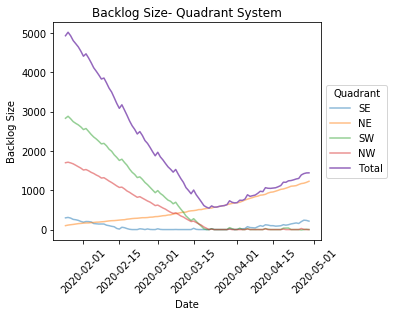

In [29]:
fig = plt.figure()
ax = plt.subplot(111)

for i in ['SE','NE','SW','NW','Total']:
    if i == 'Total':
        ax.plot(quad_backlog['Date'],quad_backlog[i])
    else:
        ax.plot(quad_backlog['Date'],quad_backlog[i],alpha = .5)
#plt.plot(df_clean.loc[df_clean['Date']>'2019-01-01','Date'],df_clean.loc[df_clean['Date']>'2019-01-01','Open_WO'])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.title("Backlog Size- Quadrant System")
plt.ylabel("Backlog Size")
plt.xlabel("Date")
plt.xticks(rotation=45) 

# Put a legend to the right of the current axis
ax.legend(['SE','NE','SW','NW','Total'],title= 'Quadrant',loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Total System Calculation

In [120]:
total_backlog = pd.DataFrame(dates)
total_backlog.columns = ['Date']
total_backlog['NE'], total_backlog['NW'],total_backlog['SE'],total_backlog['SW'] = np.nan,np.nan,np.nan,np.nan
total_backlog.loc[0,'NE'] = data_quad.loc[data_quad['quad']=='NE','backlog'].values
total_backlog.loc[0,'NW'] = data_quad.loc[data_quad['quad']=='NW','backlog'].values
total_backlog.loc[0,'SE'] = data_quad.loc[data_quad['quad']=='SE','backlog'].values
total_backlog.loc[0,'SW'] = data_quad.loc[data_quad['quad']=='SW','backlog'].values
tot_order =['NW','SW','NE','SW','SE','SW']
work_days = len(tot_order)
add_wo = 1
order=0
for i in range(1,len(dates)):
#for i in range(1,8):
    workbycrew = 0
    for j in quads:
        #print('Backlog before work created in '+ str(j)+ ' on ' + str(total_backlog.loc[i,'Date']) + ': ' + str(total_backlog.loc[i-1,j]))
        month = total_backlog.loc[i,'Date'].month
        crew_rate = wo_crew_rate.loc[wo_crew_rate['month']==month,'avg_rate'].values
        workbycrew= workbycrew + sum(absence(data_quad.loc[data_quad['quad']==j,'absence_rate'].values,data_quad.loc[data_quad['quad']==j,'crew_size'].values) * crew_rate)
        if add_wo == 1:
            work_created = wo_creation(total_backlog.loc[i,'Date'],j)
        elif add_wo == 0:
            work_created = 0
        #print('Work Created: '+ str(work_created))
        total_backlog.loc[i,j] = total_backlog.loc[i-1,j]+work_created
        #print('Backlog after work created in '+ str(j)+ ' on ' + str(total_backlog.loc[i,'Date']) + ': ' + str(total_backlog.loc[i,j]))
    weekday = total_backlog.loc[i,'Date'].weekday()
    if weekday < 5:
        work_completed = workbycrew*data_quad.loc[data_quad['quad']==tot_order[order%len(tot_order)],'worksite_diff'].values
        #print('Work Completed: '+ str(work_completed))
        total_backlog.loc[i,tot_order[order%len(tot_order)]] = total_backlog.loc[i,tot_order[order%len(tot_order)]]-work_completed
        if total_backlog.loc[i,tot_order[order%len(tot_order)]] < 0:
            total_backlog.loc[i,tot_order[order%len(tot_order)]] = 0
        order = order+1
        #print('Backlog after work completed in '+ str(tot_order[weekday])+ ' on ' + str(total_backlog.loc[i,'Date']) + ': ' + str(total_backlog.loc[i,tot_order[weekday]]))
total_backlog['Total'] = total_backlog['NE']+total_backlog['SE']+total_backlog['SW']+total_backlog['NW']

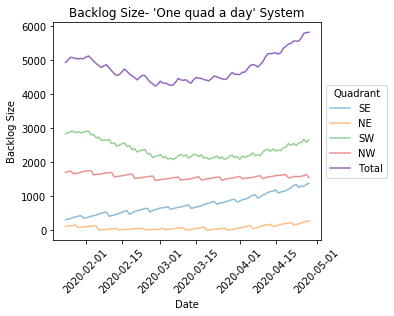

In [80]:
fig = plt.figure()
ax = plt.subplot(111)

for i in ['SE','NE','SW','NW','Total']:
    if i == 'Total':
        ax.plot(total_backlog['Date'],total_backlog[i])
    else:
        ax.plot(total_backlog['Date'],total_backlog[i],alpha = .5)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.title("Backlog Size- 'One quad a day' System")
plt.ylabel("Backlog Size")
plt.xlabel("Date")
plt.xticks(rotation=45) 

# Put a legend to the right of the current axis
ax.legend(['SE','NE','SW','NW','Total'],title= 'Quadrant',loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Put people where the work is

In [30]:
dist_backlog = pd.DataFrame(dates)
dist_backlog.columns = ['Date']
dist_backlog['NE'], dist_backlog['NW'],dist_backlog['SE'],dist_backlog['SW'], dist_backlog['Total']= np.nan,np.nan,np.nan,np.nan,np.nan
dist_backlog.loc[0,'NE'] = data_quad.loc[data_quad['quad']=='NE','backlog'].values
dist_backlog.loc[0,'NW'] = data_quad.loc[data_quad['quad']=='NW','backlog'].values
dist_backlog.loc[0,'SE'] = data_quad.loc[data_quad['quad']=='SE','backlog'].values
dist_backlog.loc[0,'SW'] = data_quad.loc[data_quad['quad']=='SW','backlog'].values
dist_backlog['Total'] = dist_backlog['NE']+dist_backlog['SE']+dist_backlog['SW']+dist_backlog['NW']
add_wo = 1
for i in range(1,len(dist_backlog)):
    crews_av = 0 
    for j in quads:
        crews_av= crews_av + sum(absence(data_quad.loc[data_quad['quad']==j,'absence_rate'].values,data_quad.loc[data_quad['quad']==j,'crew_size'].values))
    #print('Crews Available: ' + str(crews_av))
    day_dist = round((dist_backlog.iloc[i-1,1:5]/dist_backlog.loc[i-1,'Total'] * crews_av).astype(np.double))
    #print('Crew Distribution: ' + str(day_dist))
    for j in quads:
        work_completed = day_dist[j]*data_quad.loc[data_quad['quad']==j,'rate'].values*data_quad.loc[data_quad['quad']==j,'worksite_diff'].values
        #print('Completed Work in ' +str(j)+' : ' + str(work_completed))
        if add_wo == 1:
            work_created = wo_creation(dist_backlog.loc[i,'Date'],j)
        elif add_wo == 0:
            work_created = 0
        #print('Work Created in ' + str(j) +': '+ str(work_created))
        if quad_backlog.loc[i,'Date'].weekday() < working_days:
            dist_backlog.loc[i,j] = dist_backlog.loc[i-1,j]+work_created-work_completed
            if dist_backlog.loc[i,j] < 0:
                dist_backlog.loc[i,j] = 0
        else:
            dist_backlog.loc[i,j] = dist_backlog.loc[i-1,j]+work_created
    dist_backlog.loc[i,'Total'] = dist_backlog.loc[i,'NE']+dist_backlog.loc[i,'SE']+dist_backlog.loc[i,'SW']+dist_backlog.loc[i,'NW']
    #print(dist_backlog.loc[i,:])
#dist_backlog.head()

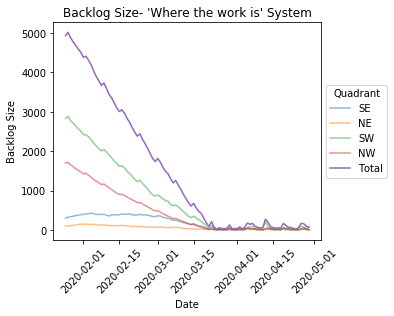

In [31]:
fig = plt.figure()
ax = plt.subplot(111)

for i in ['SE','NE','SW','NW','Total']:
    if i == 'Total':
        ax.plot(dist_backlog['Date'],dist_backlog[i])
    else:
        ax.plot(dist_backlog['Date'],dist_backlog[i],alpha = .5)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.title("Backlog Size- 'Where the work is' System")
plt.ylabel("Backlog Size")
plt.xlabel("Date")
plt.xticks(rotation=45) 

# Put a legend to the right of the current axis
ax.legend(['SE','NE','SW','NW','Total'],title= 'Quadrant',loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Ignore

In [193]:
wo_2019 = pd.read_sql('''
select  [Record ID], 
		cast([Date Create] as DATE) as Date_Create,
        cast([Date Finish] as DATE) as Date_Finish,
        [Status],
		[Clean Size],
	case when [Solid Waste Quadrant] = 'NORTHEAST' THEN 'NE'
		WHEN [Solid Waste Quadrant] = 'NORTHWEST' THEN 'NW'
		WHEN [Solid Waste Quadrant] = 'SOUTHEAST' THEN 'SE'
		WHEN [Solid Waste Quadrant] = 'SOUTHWEST' THEN 'SW'
		END AS	Quadrant
from CitiStat.dbo.CHIP_WorkOrders
where 1=1
and [Work Order Type]='Cleaning'
and [Date Create] between '2018-01-01' and '2020-01-01'
--and [Solid Waste Quadrant] in ('NORTHEAST','SOUTHEAST','SOUTHWEST','NORTHWEST')
''',conn)

#wo_2019 = pd.concat([chip_wo_red,cw_wo_red],ignore_index=True)
wo_2019 = wo_2019.drop(wo_2019[wo_2019['Quadrant'].isna()].index)
wo_2019 = wo_2019.drop(wo_2019[wo_2019['Status'].isna()].index)
wo_2019 = wo_2019.drop(wo_2019[wo_2019['Date_Create'].isna()].index)
#wo_2019 = wo_2019.drop(wo_2019[wo_2019['Date_Create']>'2019-12-31'].index)
#wo_2019['Quadrant'] = wo_2019['Quadrant'].replace(['NW','NE','SW','SE','Downtown'],['NORTHWEST','NORTHEAST','SOUTHWEST','SOUTHEAST','CENTRAL'])
#wo_2019['VRI_Focus_Area'] = wo_2019['VRI_Focus_Area'].fillna('Other')
#wo_2019 = wo_2019.drop(wo_2019[wo_2019['Quadrant']=='CENTRAL'].index)
#wo_2019['Date_Create'] = wo_2019['Date_Create'].apply(textstr2date)
#wo_2019['Date_Finish'] = wo_2019['Date_Finish'].apply(textstr2date)
#wo_2019['Year'] = pd.DatetimeIndex(wo_2019['Date_Finish']).year
#wo_2019['Month'] = pd.DatetimeIndex(wo_2019['Date_Finish']).month
#wo_2019['Date'] = pd.to_datetime(wo_2019[['Year', 'Month']].assign(DAY=1))
wo_2019['Date_Create'] = pd.to_datetime(wo_2019['Date_Create']).dt.date
wo_2019['Date_Finish'] = pd.to_datetime(wo_2019['Date_Finish']).dt.date
#wo_2019.loc[:,'Due_date'] = wo_2019["Date_Create"].apply(due_date,args=(42,))
#wo_2019['Date_Create'] = 
wo_2019 = wo_2019.reset_index()

type(wo_2019.loc[1,'Date_Create'])

datetime.date

In [205]:
df_clean = pd.DataFrame({'count' : wo_2019.groupby(['Date_Finish']).size()}).reset_index()
df_clean.columns = ['Date','WO_Count']
for j in range(len(df_clean)):
    df_clean.loc[j,'Date'] = add_years(df_clean.loc[j,'Date'],1)
    df_clean.loc[j,'Open_WO'] = oopen(wo_2019,df_clean.loc[j,'Date'])
    #df_clean.loc[j,'overdue_WO'] = oover(wo_2019,str(df_clean.loc[j,'Date']))
    #df_clean.loc[j,'percent_over'] = df_clean.loc[j,'overdue_WO']/df_clean.loc[j,'Open_WO']
#df_clean['percent_overdue'] = df_clean['overdue_WO']/df_clean['Open_WO']



In [211]:
#df_clean['Date'] = df_clean['Date'])
test = df_clean
test.loc[:,'Date'] = test.loc[:,'Date'].apply(str)
#wo_2019['Date_Finish'] = wo_2019['Date_Finish'].apply(str)
test.tail()

,Date,WO_Count,Open_WO
630,2021-01-18,1,2280.0
631,2021-01-20,42,2280.0
632,2021-01-21,82,2280.0
633,2021-01-22,81,2280.0
634,2021-01-23,51,2280.0


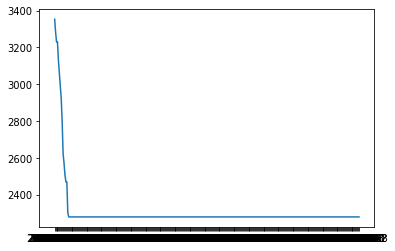

In [210]:
plt.plot(test.loc[test['Date']>'2020-01-01','Date'],test.loc[test['Date']>'2020-01-01','Open_WO'])